<center><h1>S4 MNIST Demo</h1><center>

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy

# Custom modules
from S4 import *

Using PyKeOps Cauchy kernel.


In [3]:
# Load datasets
MNIST_TRAIN = datasets.MNIST(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
MNIST_TEST = datasets.MNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

dataloader = DataLoader(MNIST_TRAIN, shuffle=True, batch_size=8)
testloader = DataLoader(MNIST_TEST, shuffle=False, batch_size=1)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# S4 Layer

At a high-level, S4 layer can be thought of as a mapping from a 1D sequence to another 1D sequence. Some of the important properties of S4:
- It's causal. The output at index $i$ depends on inputs from $0$ to $i-1$.
- It can be computed using either convolution or recurrence.
    - We use convolution during training and recurrence during sampling.
- Although it's 1D to 1D, we stack multiple S4 Layers together to process multidimensional signals.
    - In this case, different dimensions don't interact with each other.
    - Linear layers compute interactions between different signal dimensions but they cannot handle interactions through time. Therefore, linear layers complement S4 layers nicely.
- S4 doesn't provide non-linearity by itself. It needs to be combined with activation functions.

# S4 Block

Here's a simple S4 Block that encapsulates the base S4 layer with layer norm, activation and linear projection.

In [5]:
def Block(signal_dim: int, state_dim: int):
    return Residual(
        S4Base(signal_dim, state_dim, sequence_length=784),
        nn.GELU(),
        nn.Linear(signal_dim, signal_dim),
        nn.LayerNorm(signal_dim),
    )

# MNIST Classification

Although the most natural task for MNIST dataset is classification, it's not natural for S4 because S4 is a sequence-to-sequence model.

We simply flatten the images to turn them into sequences.

To use S4 as a sequence classification model, we simply take the mean of the time dimension. Using the last element in the sequence may also seem like a rational choice, but remember that S4 layer maintains a state (lossy summary of previous inputs) like an RNN. Thus, if the last output is used, the model may forget the old inputs.

In [7]:
torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 128),
    *[Block(128, 64) for _ in range(4)],
    Lambda(lambda x: x.mean(dim=1)),
    nn.Linear(128, 10),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 1 loss: 0.2688380584134428


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 2 loss: 0.06618920942063856


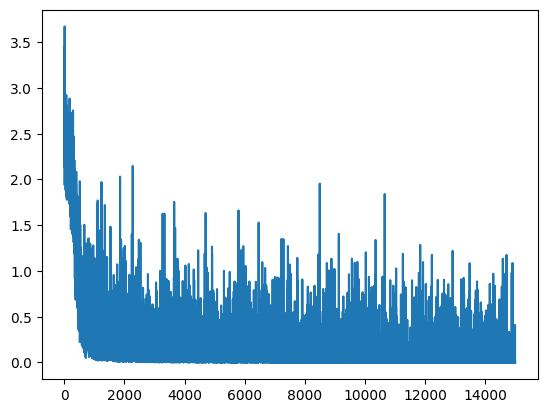

In [8]:
model.train()
for epoch in tqdm(range(2), leave=False):
    train_loss = 0.0
    for batch in tqdm(dataloader, leave=False): 
        img, y = batch
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        y = y.to(device)
        y_hat = model(img)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        losses.append(loss_val)
        train_loss += loss_val / len(dataloader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {train_loss}")

plt.plot(losses)
plt.show()

The loss plot is quite noisy due to small batch size.

In [9]:
model.eval()
total, correct = 0, 0
for x, y in testloader:
    x, y = x.to(device).reshape(-1, 784, 1), y.to(device)
    y_hat = model(x)
    y_hat = torch.argmax(y_hat, dim=-1)
    total += y.shape[0]
    correct += (y_hat == y).sum().item()
accuracy = correct / total
accuracy

0.981

# MNIST Generation

Predict the next pixel based on the given sequence of pixels.

Pixel values between 0 and 1 are given as input. The model outputs a 256 dimensional vector for each pixel. Each dimension (after applying softmax) represents the probability of an 8-bit quantized pixel value. 

In [10]:
torch.manual_seed(13)

model = Sequential(
    nn.Linear(1, 128),
    *[Block(128, 64) for _ in range(3)],
    nn.Linear(128, 256),
)
model.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=128, bias=True)
  (1): Residual(
    (0): S4Base()
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (2): Residual(
    (0): S4Base()
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (3): Residual(
    (0): S4Base()
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (4): Linear(in_features=128, out_features=256, bias=True)
)

## Overfitting Test

Before training on the full dataset, we will make sure that the model can overfit to this example:

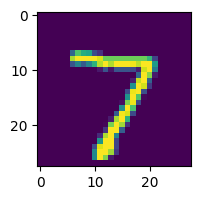

In [6]:
overfit_image = MNIST_TEST[0][0]
plt.figure(figsize=(2,2))
plt.imshow(overfit_image.reshape(28, 28, 1))

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/400 [00:00<?, ?it/s]

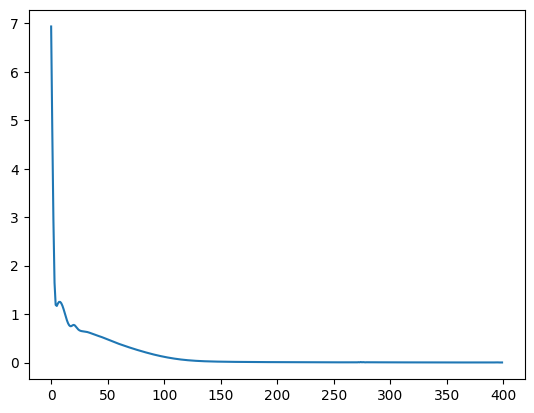

In [13]:
model.train()
for epoch in tqdm(range(400), leave=False):
    train_loss = 0.0
    for img in [overfit_image]:
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        # Shift and pad with zero to generate input
        x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        
        y = torch.mul(img, 255.0).to(torch.int64).to(device)[:,:,0]
        loss = criterion(y_hat.reshape(-1, 256), y.reshape(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()

During training, we used convolutional method for parallelization. But for autoregressive sample generation, we need to use the recurrent method.

The following method will sample from the given model `m`. It can optionally use a priming signal to start with. When `maxp` is `True`, it will always choose the value with highest probability instead of random sampling.

In [8]:
def generate_sample(m, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # The input is padded with 0 at the start
    u = f(torch.zeros(1, device=device))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s)
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in range(784 - primed_size):
        if maxp:
            p = torch.argmax(u)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        p = p / 255.0
        Y.append(p.squeeze())
        u = p.reshape(1)
        u = f(u)

    generated = torch.stack(Y).real
    # Red: generated part
    # Green: given part
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        red = torch.cat([torch.zeros_like(priming_signal), generated], dim=0)
        green = torch.cat([priming_signal, torch.zeros_like(generated)], dim=0)
    else:
        red = generated
        green = torch.zeros_like(red)
    blue = torch.zeros_like(green)
    return torch.cat([color.reshape(28, 28, 1) for color in [red, green, blue]], dim=-1)

In [34]:
def overfit_sample(start=0, maxp=False):
    model.eval()
    with torch.no_grad():
        img = overfit_image
        img = img.to(device).reshape(-1, 784, 1)
        sample = generate_sample(model, img[0, :start, :] if start > 0 else None, maxp).cpu()
        plt.figure(figsize=(2,2))
        plt.imshow(sample)

Let's sample some images.

<b style="color: red;">Red</b> parts are generated, <b style="color: green;">green</b> parts are given in the priming signal.

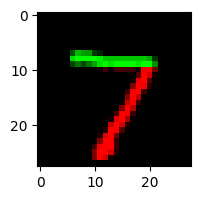

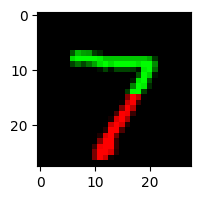

In [21]:
torch.manual_seed(42)
overfit_sample(28*10)
overfit_sample(28*15)

Let's try to generate images from scratch by sampling without any priming.

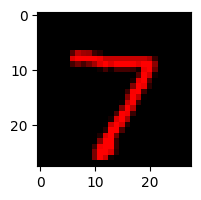

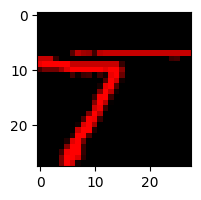

In [35]:
torch.manual_seed(1)
overfit_sample()
overfit_sample()

The second sample is really bad. During sampling, we can always choose the value with highest probability in order to get the most probable generation. This way, we will see whether we were unlucky in the previous generation.

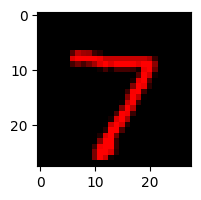

In [36]:
overfit_sample(0, True)

This looks almost exactly the same as the target image. The model can successfully overfit to a single image.

## Probability Distribution

We can actually compute the probability of an image.

In [37]:
def get_probability(model, image):
    image = image.to(device).reshape(1, 784, 1)
    # Shift and pad with zero to generate input
    x = torch.cat([torch.zeros(1, 1, 1, device=device), img[:, :-1, :]], dim=1)
    probs = torch.nn.functional.softmax(model(x), dim=-1)

    image = image.flatten()
    probs = probs.reshape(784, 256)
    ps = [pixel_probs[int(pixel.item() * 255.0)] for pixel, pixel_probs in zip(image, probs)]

    return torch.stack(ps).cpu().detach()

In [38]:
torch.prod(get_probability(model, overfit_image)).item()

0.22083613276481628

~22.1% probability of generating this exact image.

Now, let's draw an image in which each pixel represents the probability. The image should be composed almost entirely of white pixels if it's a high probability image.

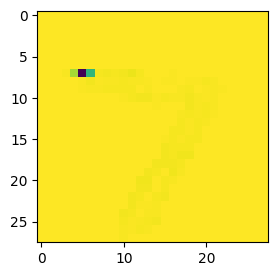

In [39]:
plt.figure(figsize=(3,3))
plt.imshow(get_probability(model, overfit_image).reshape(28, 28, 1))

Let's return to the previous bad sample and determine its probability.

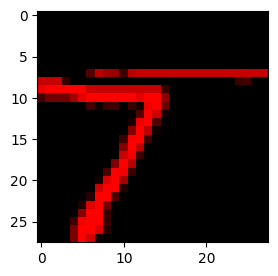

In [40]:
torch.manual_seed(1)
sample = generate_sample(model).cpu()
sample = generate_sample(model).cpu()
# Plot to make sure it's the same image
plt.figure(figsize=(3,3))
plt.imshow(sample)
sample = sample.sum(dim=-1)

0.0

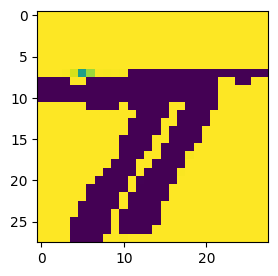

In [41]:
probs = get_probability(model, sample)
plt.figure(figsize=(3,3))
plt.imshow(probs.reshape(28, 28, 1))
torch.prod(probs).item()

The probability of this image is so low that the computed probability is 0% due to floating point precision issues. We can also see that bad parts of the generated image has low probability in the pixel probability heatmap.

## Full Dataset

In [42]:
torch.manual_seed(13)

model = Sequential(
    nn.Linear(1, 128),
    *[Block(128, 64) for _ in range(4)],
    nn.Linear(128, 256),
)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 1 loss: 0.7827094523151708


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 2 loss: 0.7091109801371906


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 3 loss: 0.6834405962586378


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 4 loss: 0.663975722368558


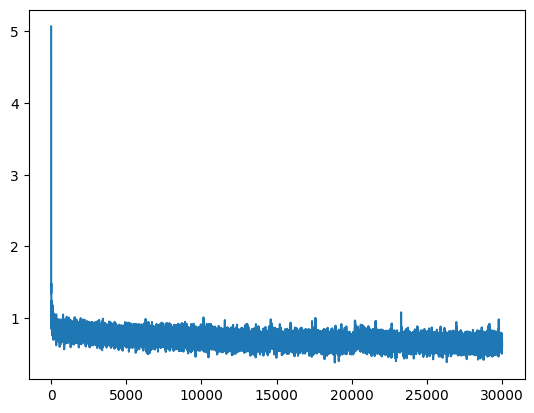

In [43]:
model.train()
for epoch in tqdm(range(4), leave=False):
    train_loss = 0.0
    for img, _ in tqdm(dataloader, leave=False):
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        # Shift and pad with zero to generate input
        x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        
        y = torch.mul(img, 255.0).to(torch.int64).to(device)[:,:,0]
        loss = criterion(y_hat.reshape(-1, 256), y.reshape(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss: {train_loss}")

plt.plot(losses)
plt.show()

In [9]:
def image_sample(img=None, start=0, maxp=False):
    model.eval()
    with torch.no_grad():
        if img is not None and start > 0:
            img = img.to(device).reshape(-1, 784, 1)[0, :start, :]
        sample = generate_sample(model, img, maxp).cpu()
        plt.figure(figsize=(2,2))
        plt.imshow(sample)

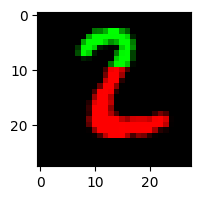

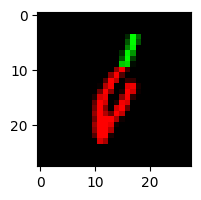

In [10]:
torch.manual_seed(11)
image_sample(MNIST_TEST[1][0], 28*10)
image_sample(MNIST_TEST[2][0], 28*10)

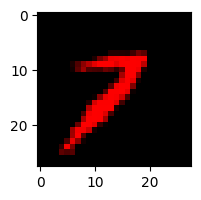

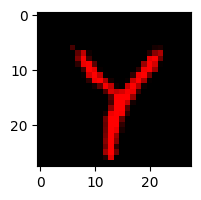

In [13]:
torch.manual_seed(0)
image_sample()
image_sample()

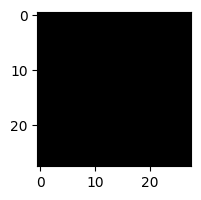

In [47]:
image_sample(maxp=True)

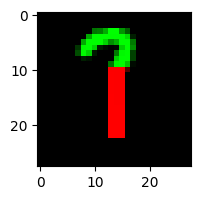

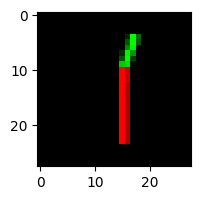

In [48]:
image_sample(MNIST_TEST[1][0], 28*10, maxp=True)
image_sample(MNIST_TEST[2][0], 28*10, maxp=True)

`maxp` option improved the results in overfitting section, but this time it seems significantly worse.

### Saving & Loading the Model

In [49]:
torch.save(model, "./models/s4-mnist.pt")

In [7]:
model = torch.load("./models/s4-mnist.pt")

# NLL

Here, we compute the average negative log likelihood (NLL) value on the test dataset.

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [11]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    nll = 0.0
    for img, _ in tqdm(testloader, leave=False):
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        # Shift and pad with zero to generate input
        x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
        y = torch.mul(img, 255.0).to(torch.int64).to(device)[:,:,0]
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        nll += criterion(y_hat.reshape(-1, 256), y.reshape(-1))
    nll /= len(MNIST_TEST)

    print("Average NLL:", nll.item())
    print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
    print("Average NLL converted to probability:", (-nll).exp().item())

  0%|          | 0/10000 [00:00<?, ?it/s]

Average NLL: 0.6474753022193909
Average NLL in base 2: 0.9341093897819519
Average NLL converted to probability: 0.5233654379844666
